<a href="https://colab.research.google.com/github/Seonghoon-Yu/PyTorch_study/blob/main/ch01/ch01_Basic_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('cookbook')

Drive already mounted at cookbook; to attempt to forcibly remount, call drive.mount("cookbook", force_remount=True).


# CUDA check

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)


cuda:0


# data 불러오고 처리하기

## 1. MNIST 데이터셋에 적용할 transformation 객체를 생성합니다.

In [ ]:
# define a transformation class in order to apply some image transformation on the MNIST dataset
from torchvision import transforms

# define transformations
data_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(1),
            transforms.RandomVerticalFlip(1),
            transforms.ToTensor(),
])

# 

## 2. MNIST datasets 을 불러오고 transform을 적용합니다.

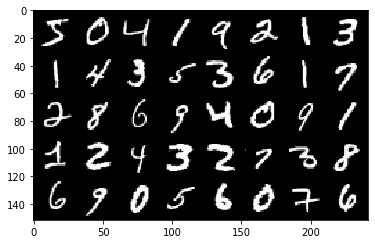

In [ ]:
# load MNIST training dataset
from torchvision import datasets

# path to store data
path2data = './data'

# load training data
train_data = datasets.MNIST(path2data, train=True, download=True, transform=data_transform)


# extract the input data and target labels
x_train, y_train = train_data.data, train_data.targets

# load the MNIST test dataset
# load validation data without data transformation
val_data = datasets.MNIST(path2data, train=False, download=True)

# extract the data and targets
x_val, y_val = val_data.data, val_data.targets

# add a new dimension to the tensors to become B*C*H*W
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1) # add one dimension at 1 index

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)

# check a few sample images
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

# Allows you to view the picture directly from the browser that ran notebook
%matplotlib inline

# define a helper function to display tensors as images
def show(img):
    # convert tensor to numpy array
    npimg = img.numpy()
    # convert to H*W*C shape from C*H*W
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

# create a grid of images and display them
# make a grid of 40 images, 8 images per row
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2) # padding means edge pixel

# call helper function
show(x_grid)

Text(0.5, 1.0, 'transpose')

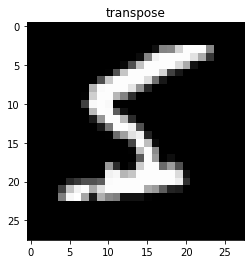

In [ ]:
# check transpose
img = train_data[0][0]
img_np = img.numpy().squeeze(0)

plt.imshow(img_np,cmap='gray')
plt.title('transpose')

## 3. tensors를 dataset으로 감쌉니다.

In [ ]:
# create a PyTorch dataset by wrapping x_train and y_train
from torch.utils.data import TensorDataset

# wrap tensors into a dataset
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

## 4. data loader를 생성합니다.

In [ ]:
# create two data loaders for the training and validaiton datasets
from torch.utils.data import DataLoader

# create a data loader from dataset
train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)

# 모델 구축하기

## 1. nn.Module을 사용해서 모델을 정의합니다.

In [ ]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # input, output, kernel_size, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


## 2. 모델을 CUDA로 전달합니다.

In [ ]:
# move the model to the CUDA device
model.to(device)
print(next(model.parameters()).device)

cuda:0


## 3. 모델 요약본을 출력합니다.

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


# loss function과 optimizer 정의하고 학습하기

## 1. loss function와 optimizer 정의하기

In [ ]:
from torch import nn
from torch import optim

# define the negative log-likelihood loss
loss_func = nn.NLLLoss(reduction='sum')

# define the Adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-4)

## 2. Training 하기

In [ ]:
# define a helper function to compute the loss value per mini-batch
def loss_batch(loss_func, xb, yb, yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric
    metric_b = metrics_batch(yb, yb_h)
    if opt is not None:
        loss.backward() # compute gradients
        opt.step() # update model parameters
        opt.zero_grad() # set gradients to zero

    return loss.item(), metric_b

# define a helper function to compute the accurary per mini-batch
def metrics_batch(target, output):
    # optain output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()

    return corrects

# define a helper fuction to compute the loss and metric values for a dataset
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    loss = 0.0
    metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        # obtain model output
        yb_h = model(xb)

        loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
        loss += loss_b
        if metric_b is not None:
            metric += metric_b
    loss /= len_data
    metric /= len_data
    return loss, metric

# define train_val function
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train() # convert to train mode
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        model.eval() # convert to evaluation mode
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        accuracy = 100 * val_metric
        print('epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f' %(epoch, train_loss, val_loss, accuracy))

# train model for a few epochs
# call train_val function
num_epochs = 5
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl)

epoch: 0, train loss: 0.174201, val loss: 0.090728, accuracy: 96.85
epoch: 1, train loss: 0.053224, val loss: 0.082158, accuracy: 97.64
epoch: 2, train loss: 0.031839, val loss: 0.058576, accuracy: 98.53
epoch: 3, train loss: 0.021631, val loss: 0.070456, accuracy: 98.30
epoch: 4, train loss: 0.016621, val loss: 0.072368, accuracy: 98.49


# model 저장하고 불러오기

## 방법 1

In [ ]:
# store the model parameters or state_dict in a file
# define path2weights
path2weights = './models/weight.pt'

# check directory
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

# store state_dict to file
torch.save(model.state_dict(), path2weights)

# definc model : weights are randomly initiated
_model = Net()

# load weights from file
weights = torch.load(path2weights)

# set weights to model : weights are set with the stored values
_model.load_state_dict(weights)


<All keys matched successfully>

## 방법 2

In [ ]:
# store the model in a file
# define a path2model
path2model = './models/model.pt'

# check directory
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

# store model and weights into a file
torch.save(model, path2model)

# define model : weights are randomly initiated
_model = Net()

# load the model from the local file
_model = torch.load(path2model)

# 추론하기

6 6


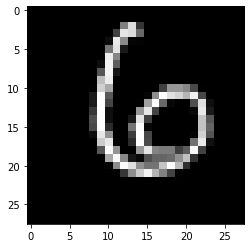

In [ ]:
# pass new data to the model
# To inference the model on a sample image from the validation dataset, get a sample data
n = 100
x = x_val[n]
y = y_val[n]
plt.imshow(x.numpy()[0],cmap='gray')

# use unsqueeze to expand dimensions to 1*C*H*W
x = x.unsqueeze(0)

# convert the type to torch.float32
x = x.type(torch.float)

# move to cuda device
x = x.to(device)

# get the model prediction
output = _model(x)

# get predicted class
pred = output.argmax(dim=1, keepdim=True)
print(pred.item(), y.item())